# Canadian Cheese

<div style="text-align: right"> December 19, 2022 </div>

<div style="text-align: right"> Final Project by Shiva Dorri </div>

## Introduction

### Question(s) of interests

Cheese has been produced in Canada since in either 1608 or 1610, and they were almost entirely farm-made. In 1864, Harvey Farrington started buying Canadian milk in commercial quantities necessary for industrial cheese making and the first commercial factory "The Pioneer" was set up in Norwich, Ontario.

Canadian cheeses are classified into `six` categories per their moisture content, which are `firm`, `soft`, `semi-soft`, `fresh`, `blue- veined`, and `hard`, with most cheeses being classified as $firm$, $soft$, or $semi-soft$. Canada presently produces over $1,050$ varieties and brands of cheese and more than half of the cheese manufacturers are located in Québec.

### Dataset description
The data were obtain from Kaggle and follows an Open Government Licence (Canada).
In this analysis, I will be investigating a question associated with a dataset regarding the different types of Canadian cheeses dataset. I am interested in finding out a model to predict the fatlevel for cheeses.

This is a discrete classification problems, so my options will be KNN, SVM, and logistic regression.


In [ ]:
# Import libraries needed

import altair as alt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import scipy
from scipy import integrate, special, stats
from scipy.stats import lognorm, loguniform, randint
from sklearn.metrics import make_scorer

alt.data_transformers.enable("data_server")

DataTransformerRegistry.enable('data_server')

## 1. Introducing and Exploring the dataset <a name="1"></a>

In [ ]:
cheese_df = pd.read_csv('data/cheese_data.csv',usecols = ['ManufacturerProvCode', 'ManufacturingTypeEn','MoisturePercent', 'Organic',
                                                          'CategoryTypeEn','MilkTypeEn','MilkTreatmentTypeEn','CheeseName', 'FatLevel'])
cheese_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),lower fat
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,lower fat
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,Provolone Sette Fette (Tre-Stelle),lower fat
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,Geai Bleu (Le),lower fat
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,Gamin (Le),lower fat


In [ ]:
cheese_df.replace(['lower fat', 'higher fat'], [1, 2], inplace = True)
cheese_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,Sieur de Duplessis (Le),1
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,Tomme Le Champ Doré,1
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,Provolone Sette Fette (Tre-Stelle),1
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,Geai Bleu (Le),1
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,Gamin (Le),1


In order to avoid violation of the golden rule, the first step before I do anything is splitting the data.
I split the data into `train_df` (80%), `test_df` (20%), and  `random_state=123` .Also, the target column (`FatLevel`) in the splits so that I can use it in EDA.

In [ ]:
train_df, test_df = train_test_split(cheese_df,test_size = 0.2,random_state = 123)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 482 to 1041
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       821 non-null    float64
 3   Organic               833 non-null    int64  
 4   CategoryTypeEn        813 non-null    object 
 5   MilkTypeEn            832 non-null    object 
 6   MilkTreatmentTypeEn   781 non-null    object 
 7   CheeseName            833 non-null    object 
 8   FatLevel              833 non-null    int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 65.1+ KB


After using .info() we can see all the different column dtypes and also all the number of null values.
We have NAN values in MoisturePercent,CategoryTypeEn,MilkTypeEn, and MilkTreatmentTypeEn. So for buliding a model Imputing will be neccessary.

In [ ]:
train_df.describe(include = 'all')

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName,FatLevel
count,833,833,821.000000,833.000000,813,832,781,833,833.000000
unique,10,3,NaN,NaN,6,8,3,830,NaN
top,QC,Industrial,NaN,NaN,Firm Cheese,Cow,Pasteurized,Boerenkaas,NaN
freq,635,370,NaN,NaN,271,596,648,2,NaN
mean,NaN,NaN,47.052741,0.091236,NaN,NaN,NaN,NaN,1.342137
std,NaN,NaN,9.660351,0.288118,NaN,NaN,NaN,NaN,0.474710
min,NaN,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,40.000000,0.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,46.000000,0.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,52.000000,0.000000,NaN,NaN,NaN,NaN,2.000000


In out data set: most_unique = CheeseName, missing_cat = CategoryTypeEn, MilkTreatmentTypeEn, and missing_num = MoisturePercent

In [ ]:
#cat_feature_list = train_df.select_dtypes('object').columns.tolist()
cat_feature_list = ['ManufacturerProvCode','ManufacturingTypeEn','CategoryTypeEn','MilkTypeEn','MilkTreatmentTypeEn','FatLevel']
alt.Chart(train_df).mark_bar(opacity = 0.7).encode(
     alt.X(alt.repeat(), type = 'nominal'),
     alt.Y('count():Q', stack=None ),
     alt.Color('FatLevel')
).properties(width = 200, height = 400).repeat(cat_feature_list, columns = 3)

alt.RepeatChart(...)

In [ ]:
num_feature_list = ['MoisturePercent','Organic']
alt.Chart(train_df).mark_bar(opacity = 0.7).encode(
     alt.X(alt.repeat(),type = 'quantitative'),
     alt.Y('count():Q'),
     alt.Color('FatLevel')
).properties(width = 300, height = 400).repeat(num_feature_list, columns = 3)

alt.RepeatChart(...)

Let's have EDA for the data set. From the visualization below we can see Cheese in QC is significantly more than other province in Canada. Industrial soft cheese are pupular product. It seems milk is pastorized cow milk and lower fat is the popular chees however they are not organic.

Since my model will predict the probability of a binary (lower fat/higher fat) event occurring, logistic regression will be my first choice. let see how the model performs. If it fails, then I will try using SVM with RBF kernel or KNN.

In [ ]:
X_train = train_df.drop(columns = 'FatLevel')
X_test = test_df.drop(columns = 'FatLevel')
y_train = train_df['FatLevel']
y_test = test_df['FatLevel']

X_train.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,CheeseName
482,QC,Artisan,48.0,0,Semi-soft Cheese,Cow,Pasteurized,Raclette Griffon
896,QC,Artisan,45.0,0,Veined Cheeses,Cow,Pasteurized,Rébellion 1837
421,QC,Industrial,50.0,0,Soft Cheese,Cow,Pasteurized,Mini-Brie
929,BC,Artisan,40.0,0,Semi-soft Cheese,Cow,Pasteurized,Aged Farmhouse
737,QC,Artisan,65.0,0,Fresh Cheese,Cow,Pasteurized,Ricotta (l'Ancêtre)


## 2. Preprocessing and building pipelines

Now it is time to categorize X-train columns to lists named of `categorical_feats`, `numeric_feats`, `ordinal_feat` and `binary_feats`.

In [ ]:
categorical_feats = ['ManufacturerProvCode','CategoryTypeEn','MilkTypeEn', 'CheeseName']
numeric_feats = ['MoisturePercent','Organic']
ordinal_feat = ['ManufacturingTypeEn','MilkTreatmentTypeEn']
binary_feats = []
drop_features = ['CheeseName']

In [ ]:
# Ordering the values in 'ManufacturingTypeEn' and naming the list ManufacturingType_order
#print (X_train['ManufacturingTypeEn'].unique())
ManufacturingType_order = ['Farmstead', 'Industrial', 'Artisan']

In [ ]:
#Ordering the values in 'MilkTreatmentTypeEn' and naming the list MilkTreatment_order
#print (X_train['MilkTreatmentTypeEn'].unique())
MilkTreatment_order = ['Raw Milk', 'Pasteurized', 'Thermised']

In [ ]:
# Pipelines
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))
numeric_transformer = make_pipeline(SimpleImputer(strategy="mean"),StandardScaler())
ordinal_transformer1 = make_pipeline(SimpleImputer(strategy="most_frequent"),OrdinalEncoder(categories=[ManufacturingType_order], dtype=int))
ordinal_transformer2 = make_pipeline(SimpleImputer(strategy="most_frequent"),OrdinalEncoder(categories=[MilkTreatment_order], dtype=int))

In [ ]:
# Column transformer
preprocessor = make_column_transformer((categorical_transformer, categorical_feats),(numeric_transformer, numeric_feats),("drop", drop_features),
                                       (ordinal_transformer1, ['ManufacturingTypeEn']),(ordinal_transformer2, ['MilkTreatmentTypeEn']))



# 3. Model Building

For calculating `accuracy`,`f1`,`recall`,`precision`, I need to replace Lower fat and higher fat with 1 and 2. I consider Lower fat as positive class.

In [ ]:
#train_df.replace(['lower fat', 'higher fat'], [1, 2])

Since it's important to build a dummy classifier to compare my model to.
I make a DummyClassifier using `strategy="most_frequent"`.Also,I will carry out 5-fold cross validation on X_train and y_train using  cross_validate().

In [ ]:
dummy_model = DummyClassifier(strategy="prior")
dummy_scores = pd.DataFrame(cross_validate(dummy_model, X_train, y_train, cv =5, return_train_score=True,
                                           scoring = ['accuracy','f1','recall','precision']))

In [ ]:
results_dict = {'Dummy': {'mean_train_accuracy': round(dummy_scores["train_accuracy"].mean(),4),
                          'mean_test_accuracy': round(dummy_scores["test_accuracy"].mean(),4),
                          'mean_train_f1' :round(dummy_scores["train_f1"].mean(),4),
                               'mean_test_f1' : round(dummy_scores["test_f1"].mean(),4),
                               'mean_train_recall' :round(dummy_scores["train_recall"].mean(),4),
                               'mean_test_recall': round(dummy_scores["test_recall"].mean(),4),
                               'mean_train_precision': round(dummy_scores["train_precision"].mean(),4),
                               'mean_test_precision': round(dummy_scores["test_precision"].mean(),4),
                          'mean_fit_time (s)': round(dummy_scores["fit_time"].mean(),4),
                          'mean_score_time (s)': round(dummy_scores["score_time"].mean(),4)}}





models = {"Logistic Regression": LogisticRegression(class_weight="balanced"),"RBF SVM": SVC(class_weight="balanced"),"Random Forest Classifier": RandomForestClassifier(class_weight="balanced"),
          "KNN": KNeighborsClassifier(), "Decision Tree" : DecisionTreeClassifier(class_weight="balanced")}

for model_name, model in models.items():
    print(model_name, ":")

    pipe = make_pipeline(preprocessor, model)

    scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True,scoring = ['accuracy','f1','recall','precision'])

    results_dict[model_name] ={'mean_train_accuracy': scores["train_accuracy"].mean().round(4),
                               'mean_test_accuracy': scores["test_accuracy"].mean().round(4),
                               'mean_train_f1' :scores["train_f1"].mean().round(4),
                               'mean_test_f1' : scores["test_f1"].mean().round(4),
                               'mean_train_recall' :scores["train_recall"].mean().round(4),
                               'mean_test_recall': scores["test_recall"].mean().round(4),
                               'mean_train_precision': scores["train_precision"].mean().round(4),
                               'mean_test_precision': scores["test_precision"].mean().round(4),
                               'mean_fit_time (s)': scores["fit_time"].mean().round(4),
                               'mean_score_time (s)': scores["score_time"].mean().round(4)
                               }

results_df = pd.DataFrame(results_dict).T
results_df

Logistic Regression :
RBF SVM :
Random Forest Classifier :
KNN :
Decision Tree :


,mean_train_accuracy,mean_test_accuracy,mean_train_f1,mean_test_f1,mean_train_recall,mean_test_recall,mean_train_precision,mean_test_precision,mean_fit_time (s),mean_score_time (s)
Dummy,0.6579,0.6579,0.7936,0.7936,1.0000,1.0000,0.6579,0.6579,0.0012,0.0039
Logistic Regression,0.8793,0.7647,0.9023,0.8146,0.8472,0.7865,0.9652,0.8450,0.0601,0.0203
RBF SVM,0.8622,0.7803,0.8882,0.8241,0.8317,0.7829,0.9529,0.8704,0.0479,0.0213
Random Forest Classifier,1.0000,0.8211,1.0000,0.8713,1.0000,0.9216,1.0000,0.8267,0.2906,0.0335
KNN,0.8733,0.8247,0.9053,0.8682,0.9202,0.8778,0.8913,0.8592,0.0268,0.0295
Decision Tree,1.0000,0.8356,1.0000,0.8698,1.0000,0.8359,1.0000,0.9068,0.0323,0.0178


In the training dataset, our class target column had many more lower fat than higher fat examples.That is reffer to imbalance training data set, so I will use class_weight='balanced' for solving that issue.
According to above scoring table, DecisionTreeClassifier has the highest validation score, and Knn, Random Forest Classifier,RBF SVM, and Logistic Regression are in nexet level. Suprisingly, Dummy classifier has the lowest score in this list!

I will tune hyperparameter for decisiontreeclassifier, knn and logestic regression for bulding models using f1 as scoring regulator and will compare scores.

In [ ]:
param_grid = {"decisiontreeclassifier__max_depth": scipy.stats.randint(low=1, high=100)}

dt_pipeline = make_pipeline(preprocessor,DecisionTreeClassifier(class_weight='balanced'))
random_search_dt = RandomizedSearchCV(dt_pipeline, param_grid, cv=5, return_train_score=True,
                           verbose=1, n_jobs=-1, scoring= 'f1', n_iter = 6)
random_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ManufacturerProvCode',
                                                                                'CategoryTypeEn',
                                                                                'MilkTypeEn',
                

In [ ]:
best_model_dt = random_search_dt.best_estimator_
best_model_dt.fit(X_train, y_train)
training_score = random_search_dt.score(X_train, y_train)
testing_score = random_search_dt.score(X_test, y_test)
print(training_score)
print(testing_score)

1.0
0.8603773584905661


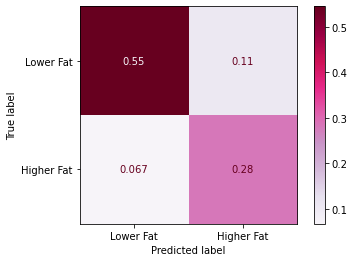

In [ ]:
cm_plot_dt = plot_confusion_matrix(random_search_dt, X_test, y_test,display_labels=["Lower Fat", "Higher Fat"],normalize='all',cmap="PuRd")
cm_plot_dt

In [ ]:
predicted_y = random_search_dt.predict(X_test)
print(classification_report(y_test, predicted_y, digits=4,target_names=["Lower Fat", "Higher Fat"]))

              precision    recall  f1-score   support

   Lower Fat     0.8906    0.8382    0.8636       136
  Higher Fat     0.7284    0.8082    0.7662        73

    accuracy                         0.8278       209
   macro avg     0.8095    0.8232    0.8149       209
weighted avg     0.8340    0.8278    0.8296       209



Ovefitting might becase of small sample

In [ ]:
param_dist = {"kneighborsclassifier__n_neighbors" : np.arange(1, 100),
             "kneighborsclassifier__weights" : ['uniform', 'distance']}

knn_pipeline = make_pipeline(preprocessor,KNeighborsClassifier())
random_search_knn = RandomizedSearchCV(knn_pipeline, param_dist, cv=5, verbose=1, n_jobs=-1,scoring ="f1", n_iter=10)
random_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ManufacturerProvCode',
                                                                                'CategoryTypeEn',
                                                                                'MilkTypeEn',
                

In [ ]:
best_model_knn = random_search_knn.best_estimator_
best_model_knn.fit(X_train, y_train)
training_score = random_search_knn.score(X_train, y_train)
testing_score = random_search_knn.score(X_test, y_test)
print(training_score)
print(testing_score)

1.0
0.8409090909090909


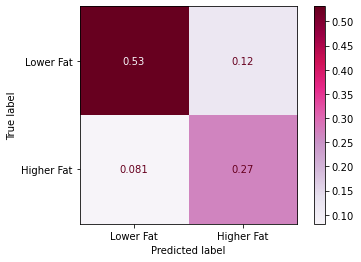

In [ ]:
cm_plot_knn = plot_confusion_matrix(random_search_knn, X_test, y_test,display_labels=["Lower Fat", "Higher Fat"],normalize='all',cmap="PuRd")
cm_plot_knn

In [ ]:
predicted_y = random_search_knn.predict(X_test)
print(classification_report(y_test, predicted_y, digits=4,target_names=["Lower Fat", "Higher Fat"]))

              precision    recall  f1-score   support

   Lower Fat     0.8672    0.8162    0.8409       136
  Higher Fat     0.6914    0.7671    0.7273        73

    accuracy                         0.7990       209
   macro avg     0.7793    0.7916    0.7841       209
weighted avg     0.8058    0.7990    0.8012       209



Balanced logistic regression model has better mean validation accuracy than the dummy classifier.Also, balanced logistic regression model shows higher validation precision scores than validation recall scores.

In [ ]:
param_grid = {"logisticregression__C": scipy.stats.uniform(0, 100)}
main_pipe = make_pipeline(preprocessor, LogisticRegression(class_weight = "balanced",max_iter=2000))
random_search_lr = RandomizedSearchCV(main_pipe,param_grid,n_iter=10,cv =5, random_state= 123, n_jobs=-1,scoring ="f1", verbose=3,return_train_score=True  )
random_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END logisticregression__C=69.64691855978616;, score=(train=1.000, test=0.845) total time=   0.1s
[CV 2/5] END logisticregression__C=69.64691855978616;, score=(train=1.000, test=0.851) total time=   0.1s
[CV 3/5] END logisticregression__C=69.64691855978616;, score=(train=1.000, test=0.807) total time=   0.1s
[CV 4/5] END logisticregression__C=69.64691855978616;, score=(train=1.000, test=0.843) total time=   0.1s
[CV 5/5] END logisticregression__C=69.64691855978616;, score=(train=1.000, test=0.806) total time=   0.1s
[CV 1/5] END logisticregression__C=28.613933495037948;, score=(train=1.000, test=0.840) total time=   0.1s
[CV 2/5] END logisticregression__C=28.613933495037948;, score=(train=1.000, test=0.855) total time=   0.1s
[CV 3/5] END logisticregression__C=28.613933495037948;, score=(train=1.000, test=0.798) total time=   0.1s
[CV 4/5] END logisticregression__C=28.613933495037948;, score=(train=1.000, test=0.837) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ManufacturerProvCode',
                                                                                'CategoryTypeEn',
                                                                                'MilkTypeEn',
                

In [ ]:
best_model_lr = random_search_lr.best_estimator_
best_model_lr.fit(X_train, y_train)
training_score_lr = random_search_lr.score(X_train, y_train)
testing_score_lr = random_search_lr.score(X_test, y_test)
print(training_score_lr)
print(testing_score_lr)

1.0
0.8339483394833948


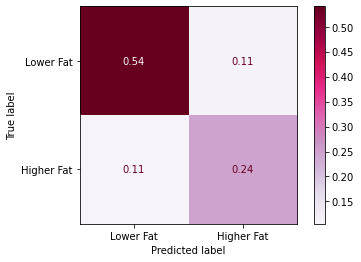

In [ ]:
cm_plot_lr = plot_confusion_matrix(random_search_lr, X_test, y_test,display_labels=["Lower Fat", "Higher Fat"], normalize='all',cmap="PuRd")
cm_plot_lr

In [ ]:
predicted_y = random_search_lr.predict(X_test)
print(classification_report(y_test, predicted_y, digits=4,target_names=["Lower Fat", "Higher Fat"]))

              precision    recall  f1-score   support

   Lower Fat     0.8370    0.8309    0.8339       136
  Higher Fat     0.6892    0.6986    0.6939        73

    accuracy                         0.7847       209
   macro avg     0.7631    0.7648    0.7639       209
weighted avg     0.7854    0.7847    0.7850       209



In [ ]:
rf_pipeline = make_pipeline(preprocessor, RandomForestClassifier(class_weight = "balanced", random_state=123))

param_dist = {"randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
              "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20)}

random_search_rf = RandomizedSearchCV(rf_pipeline,param_dist,n_iter=50,cv=5,verbose=1,n_jobs=-1,scoring ="f1",random_state=123,)
random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ManufacturerProvCode',
                                                                                'CategoryTypeEn',
                                                                                'MilkTypeEn',
                

In [ ]:
best_model_rf = random_search_rf.best_estimator_
best_model_rf.fit(X_train, y_train)
training_score_rf = random_search_rf.score(X_train, y_train)
testing_score_rf = random_search_rf.score(X_test, y_test)
print(training_score_rf)
print(testing_score_rf)

0.9138576779026217
0.8178438661710037


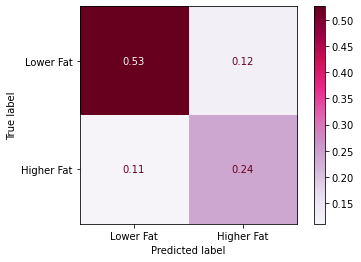

In [ ]:
cm_plot_rf = plot_confusion_matrix(random_search_rf, X_test, y_test,display_labels=["Lower Fat", "Higher Fat"],normalize='all',cmap="PuRd")
cm_plot_rf

In [ ]:
predicted_y = random_search_rf.predict(X_test)
print(classification_report(y_test, predicted_y, digits=4,target_names=["Lower Fat", "Higher Fat"]))

              precision    recall  f1-score   support

   Lower Fat     0.8271    0.8088    0.8178       136
  Higher Fat     0.6579    0.6849    0.6711        73

    accuracy                         0.7656       209
   macro avg     0.7425    0.7469    0.7445       209
weighted avg     0.7680    0.7656    0.7666       209



In [ ]:
param_grid = {"svc__C": scipy.stats.uniform(0, 100),"svc__gamma": scipy.stats.uniform(0, 100)}

svc_pipeline = make_pipeline(preprocessor,SVC(class_weight = "balanced", random_state=123))
random_search_svc = RandomizedSearchCV(svc_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1,scoring ="f1", n_iter=10)
random_search_svc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['ManufacturerProvCode',
                                                                                'CategoryTypeEn',
                                                                                'MilkTypeEn',
                

In [ ]:
best_model_svc = random_search_svc.best_estimator_
best_model_svc.fit(X_train, y_train)
training_score_svc = random_search_svc.score(X_train, y_train)
testing_score_svc = random_search_svc.score(X_test, y_test)
print(training_score_svc)
print(testing_score_svc)

1.0
0.856060606060606


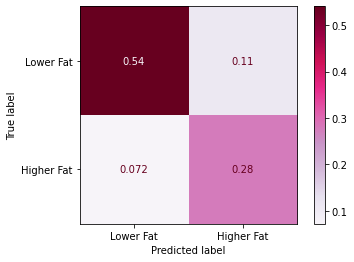

In [ ]:
cm_plot_svc = plot_confusion_matrix(random_search_svc, X_test, y_test,display_labels=["Lower Fat", "Higher Fat"], normalize='all',cmap="PuRd")
cm_plot_svc

In [ ]:
predicted_y = random_search_svc.predict(X_test)
print(classification_report(y_test, predicted_y, digits=4,target_names=["Lower Fat", "Higher Fat"]))

              precision    recall  f1-score   support

   Lower Fat     0.8828    0.8309    0.8561       136
  Higher Fat     0.7160    0.7945    0.7532        73

    accuracy                         0.8182       209
   macro avg     0.7994    0.8127    0.8047       209
weighted avg     0.8246    0.8182    0.8201       209



Since there is no imprtance score on a specific class, so weighted average will be a good choice for comparing. It seems `RandomForestClassifier` and `decisiontreeclassifier` models have the highest weighted avg. I am interested in digging more to find out why RandomForestClassifier won't preformed good after tuning hyperparameter.
Considering that Lower Fat as "positive" class, we will have 136 example lower fat cheese and the below score table to compare:

| Model                                         |Accrucy  |weighted avg Recall |weighted avg Precision
|-----------------------------------------------|---------|------------------- |----------------------
|Decision Tree                                  |0.8296   | 0.8395             |0.8949
|<font color='green'>**dt_best model**</font>   |         | 0.8283             |0.8247
| knn                                           | 0.8247  | 0.8778             |0.8592
|knn_best model                                 |         | 0.8038             |0.8045
|Logestic Regression                            | 0.7647  | 0.7865             |0.8450
|Logestic Regression_best model                 |         | 0.7844             |0.7854  
|RandomForestClassifier                         |0.8211   | 0.9216             |0.8592
|RandomForestClassifier_best model              |         | 0.7656             |0.7680
|RBF SVM                                        |0.7803   | 0.7829             |0.8704
|RBF SVM_best model                             |         | 0.8182             |0.8246


Finally, we have belows as a best hyperparameter for `Desicision Tree` model and the accrucy on test data set is `0.8654`

In [ ]:
optimal_parameters = random_search_dt.best_params_
optimal_score = random_search_dt.best_score_
print(optimal_parameters, optimal_score)

{'decisiontreeclassifier__max_depth': 42} 0.8654368914975941


## Discussion

We have a data set for pedicting canadian cheese fat. It was a classification problem including two classes : Lower fat and Higher fat. From the visulisation, we can see this is a imbalance problem. The other thing is we have a significantly more examples from QC province, and I think that would impact to the result. Also we can see Industrial, pastorized, and cow has many more expamles as well.

From the first score table, Decision tree was the best fit for the training data set. `DecisionTreeClassifier(class_weight='balanced',max_depth=42)`.
At the end of the day, it make sense  that Decision tree classifer would be a good model, but we have overfiiting.
On the other hande, RandomForestClassifier doesn't have overfitting issue however, will sacrefise high scores for tuning hyperparamete.  

Since this was a classification problem with binary choices, I thought Logestic regression would be the best model. However, the table shows a different result. For tuning hyper parameter, I will use f1 score as the best score for tuning classification model. My second assupmtion that was rejectd by scoring table was SVC model ass the test score showed very low score for it.Eventhough the test score is good enough for Desicion Tree , we have overfitting. It might because of small size data set, however I would like to make sure if I didn't use irrelevent feature.


For next steps, I will drop features one by one and will test how my model will performe. Also would like to check MAPE score on my models as well. Would my model have better hyperparameter or not? Would Logestig Regression be a better model?

| Model                                         |Accrucy  |weighted avg Recall |weighted avg Precision
|-----------------------------------------------|---------|------------------- |----------------------
|Decision Tree                                  |0.8296   | 0.8395             |0.8949
|<font color='green'>**dt_best model**</font>   |         | 0.8283             |0.8247
| knn                                           | 0.8247  | 0.8778             |0.8592
|knn_best model                                 |         | 0.8038             |0.8045
|Logestic Regression                            | 0.7647  | 0.7865             |0.8450
|Logestic Regression_best model                 |         | 0.7844             |0.7854             

## References

### Resources used

modified version of Canada's Open Government Portal

Introduction of cheese
https://en.wikipedia.org/wiki/Canadian_cheese